# Truncation Sampling Visualization Colab

This notebook provides a quick way to visualize how a few truncation sampling algorithms ([top-p](https://arxiv.org/abs/1904.09751), [eta-sampling](https://arxiv.org/abs/2210.15191)) modify the distribution provided by a language model.

Truncation sampling decides at each conditional distribution which words to "allow" and which words to "truncate" (set to 0 probability.) Such methods are widely used heuristics in natural language generation, and are often evaluated at the sequence level (do I tend to generate a diverse distribution over well-formed sequences?) But **the word-level truncation decisions can often be unintuitive or undesirable, and they decide what is allowed to be generated.** This colab is intended to give a quick way to explore these decisions.

You specify a natural language string (and optionally change the model or truncation hyperparameters), and you get a plot that shows:

 - The shape of the conditional distribution over the last word.
 - A few of the most likely words under the model
 - The truncation thresholds (where each truncation algorithm sets remaining probabilities to 0.)
 - A few of the  **least** likely words allowed (not truncated) by each truncation algorithm.

There are myriad known biases and problems with the default model used here, `gpt2`. This codebase is intended to help in the characterization of the failures of these models; it can generate offensive text.

 If this colab is useful to you, you can find out more in the paper 
 
 - John Hewitt, Christopher D. Manning, Percy Liang. [_Truncation Sampling as Language Model Desmoothing_](https://arxiv.org/abs/2210.15191) (EMNLP Findings 2022).
 - Github: https://github.com/john-hewitt/truncation-sampling


### Installation of Prereqs

In [1]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
import torch
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette(n_colors=5)
in_c, out_c, p_c, e_c, h_c = colors

import argparse
import urllib
import json
import random

from tqdm import tqdm
import math

### Utility Code

- Includes code for top-p, epsilon, eta-sampling.
- Includes plotting code.

In [3]:
import torch
import transformers
import random

device = 'cuda'

class TypicalLogitsWarper(transformers.LogitsWarper):
    """
    Code largely taken from https://github.com/cimeister/typical-sampling
    """
    def __init__(self, mass: float = 0.9, filter_value: float = -float("Inf"), min_tokens_to_keep: int = 1):

        self.filter_value = filter_value
        self.mass = mass
        self.min_tokens_to_keep = min_tokens_to_keep

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:

        # calculate entropy
        normalized = torch.nn.functional.log_softmax(scores, dim=-1)
        p = torch.exp(normalized)
        ent = -(normalized * p).nansum(-1, keepdim=True)

        # shift and sort
        shifted_scores = torch.abs((-normalized) - ent)
        sorted_scores, sorted_indices = torch.sort(shifted_scores, descending=False)
        sorted_logits = scores.gather(-1, sorted_indices)
        cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)

        # Remove tokens with cumulative mass above the threshold
        last_ind = (cumulative_probs < self.mass).sum(dim=1)
        last_ind[last_ind < 0] = 0
        sorted_indices_to_remove = sorted_scores > sorted_scores.gather(1, last_ind.view(-1, 1))
        if self.min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., : self.min_tokens_to_keep] = 0
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)

        scores = scores.masked_fill(indices_to_remove, self.filter_value)
        return scores

class TopPLogitsWarper(transformers.LogitsWarper):
  """
  [`LogitsWarper`] that performs top-p, i.e. restricting to top tokens summing to prob_cut_off <= prob_cut_off.
  Args:
      top_p (`float`):
          If set to < 1, only the most probable tokens with probabilities that add up to `top_p` or higher are kept
          for generation.
      filter_value (`float`, *optional*, defaults to `-float("Inf")`):
          All filtered values will be set to this float value.
      min_tokens_to_keep (`int`, *optional*, defaults to 1):
          Minimum number of tokens that cannot be filtered.
  """

  def __init__(self, top_p: float, filter_value: float = -float("Inf"), min_tokens_to_keep: int = 1):
    top_p = float(top_p)
    if top_p < 0 or top_p > 1.0:
      raise ValueError(f"`top_p` has to be a float > 0 and < 1, but is {top_p}")

    self.top_p = top_p
    self.filter_value = filter_value
    self.min_tokens_to_keep = min_tokens_to_keep

  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
    sorted_logits, sorted_indices = torch.sort(scores, descending=True)
    cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)

    # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
    sorted_indices_to_remove = cumulative_probs > self.top_p
    if self.min_tokens_to_keep > 1:
      # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
      sorted_indices_to_remove[..., : self.min_tokens_to_keep - 1] = 0
    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    # scatter sorted tensors to original indexing
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores = scores.masked_fill(indices_to_remove, self.filter_value)
    return scores

  def determine_divergence(self, scores, chosen_word):
    """
    Determines the extent to which a word violates the truncation threshold of this warper.
    Values above 0 indicate that the word would be disallowed (i.e., assigned zero probability) under this truncation method.
    Arguments:
        scores: Tensor of size (1, vocab_size)
        chosen_word: int
    Returns:
        how far past the top-p the word _before_ this in the sorted vocab is
        i.e., if the word _before_ this already accounted for p probability,
        the top-p truncation would have stopped there.
    """
    #import pdb; pdb.set_trace()
    sorted_logits, sorted_indices = torch.sort(scores, descending=True)
    cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
    index = (sorted_indices == chosen_word).nonzero(as_tuple=True)[1]
    cum_pr = cumulative_probs[0,index]
    pr = cumulative_probs[0,index] - (cumulative_probs[0,index-1] if index > 1 else 0)
    return max(cum_pr-pr-self.top_p, 0)

class EtaWarper(transformers.LogitsWarper):
  """Our proposed eta sampling warper."""
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.filter_value = -float("Inf")

  def __call__(self, input_ids, scores) -> torch.FloatTensor:
    probabilities = scores.softmax(dim=-1)
    entropy = torch.distributions.Categorical(probs=(scores).softmax(dim=-1)).entropy()
    epsilon = min(self.epsilon, torch.sqrt(torch.tensor(self.epsilon))*torch.exp(-entropy))
    indices_to_remove = probabilities < epsilon
    max_word = torch.argmax(scores,dim=-1)
    indices_to_remove[...,max_word.squeeze()] = 0
    new_scores = scores.masked_fill(indices_to_remove, self.filter_value)
    return new_scores

class EntropyWarper(transformers.LogitsWarper):
  """Same as EtaWarper; here for historical reasons."""
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.filter_value = -float("Inf")

  def __call__(self, input_ids, scores, return_epsilon=False) -> torch.FloatTensor:
    probabilities = scores.softmax(dim=-1)
    entropy = torch.distributions.Categorical(probs=(scores).softmax(dim=-1)).entropy()
    epsilon = min(self.epsilon, torch.sqrt(torch.tensor(self.epsilon))*torch.exp(-entropy))
    indices_to_remove = probabilities < epsilon
    max_word = torch.argmax(scores,dim=-1)
    indices_to_remove[...,max_word.squeeze()] = 0
    new_scores = scores.masked_fill(indices_to_remove, self.filter_value)
    if return_epsilon:
      return new_scores, torch.tensor(epsilon)
    else:
      return new_scores

class EpsilonWarper(transformers.LogitsWarper):
  """
  [`LogitsWarper`] that performs epsilon, i.e. restricting to tokens with absolute prob > prob_cut_off.
  Takes single argmax token if no tokens satisfy this constraint.
  Args:
      epsilon (`float`):
          If set to > 0, only the most tokens with probabilities `epsilon` or higher are kept for generation.
      filter_value (`float`, *optional*, defaults to `-float("Inf")`):
          All filtered values will be set to this float value.
  """
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.filter_value = -float("Inf")

  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
    probabilities = scores.softmax(dim=-1)
    indices_to_remove = probabilities < self.epsilon
    max_word = torch.argmax(scores,dim=-1)
    indices_to_remove[...,max_word.squeeze()] = 0
    new_scores = scores.masked_fill(indices_to_remove, self.filter_value)
    return new_scores

  def determine_divergence(self, scores, chosen_word):
    """
    Determines the extent to which a word violates the truncation threshold of this warper.
    Values above 0 indicate that the word would be disallowed (i.e., assigned zero probability) under this truncation method.
    Arguments:
        scores: Tensor of size (1, vocab_size)
        chosen_word: int
    Returns:
        how much less probability than (1-lmbda)*p_smoothing(chosen_word) 
        was assigned by this distribution to chosen_word; i.e., how much
        less likely it is than it would have needed to be if it were not
        to be truncated.
    """
    probabilities = scores.softmax(dim=-1)
    divergences = probabilities - self.epsilon
    return max(0, -divergences[0, chosen_word])

In [4]:
font = {
        'weight': 'normal',
        'size': 16,
        }

def plot(gold_indices, topp_warper, epsilon_warper, eta_warper, entropy, probs, logits):
  unwarped_probs = logits.softmax(dim=-1)
  eta_warped_probs, effective_eps = eta_warper(None, logits, return_epsilon=True)
  effective_eps = effective_eps.cpu().item()
  topp_warped_probs = topp_warper(None, logits)
  epsilon_warped_probs = epsilon_warper(None, logits)
  eta_cutoff_index = torch.sum(torch.logical_not(eta_warped_probs.isinf())).cpu().item()
  epsilon_cutoff_index = torch.sum(torch.logical_not(epsilon_warped_probs.isinf())).cpu().item()
  topp_cutoff_index = torch.sum(torch.logical_not(topp_warped_probs.isinf())).cpu().item()

  eta_tokens = []
  epsilon_tokens = []
  topp_tokens = []
  most_likely = []
  for index, word_id in enumerate(sorted(range(50256), key=lambda x:-unwarped_probs[0][x])): #range(50256):
    eta_accepted = not(bool(eta_warped_probs.reshape(-1)[word_id].isinf()))
    topp_accepted = not(bool(topp_warped_probs.reshape(-1)[word_id].isinf()))
    if index < 10:
      most_likely.append(word_id)
    if (index+1) > (eta_cutoff_index - 10) and (index+1) <= eta_cutoff_index:
      eta_tokens.append(word_id)
    if (index+1) > (topp_cutoff_index - 10) and (index+1) <= topp_cutoff_index:
      topp_tokens.append(word_id)

  plt.clf()
  plt.figure(figsize=(6.4, 3.2))
  y, _ = torch.sort(probs.reshape(-1).cpu(), descending=True)
  x = list(range(1, len(y)+1))
  cutoff = int(max(eta_cutoff_index, topp_cutoff_index, epsilon_cutoff_index)*1.2)
  x = x[:cutoff]
  y = y[:cutoff]
  ymin =0
  ymax=1
  plt.text(0, min(y).item()*0.01, '~Most Likely~\n'+'\n'.join(map(lambda x: tokenizer.decode(x).replace('\n', '\\n'), most_likely[:5])), verticalalignment='top', horizontalalignment='center', fontdict=font)
  plt.text(topp_cutoff_index+.5, min(y).item()*0.00005, '~topp~\n'+'\n'.join(map(lambda x: tokenizer.decode(x).replace('\n', '\\n'), topp_tokens[:5])), verticalalignment='top', horizontalalignment='center', fontdict=font)
  plt.text(eta_cutoff_index+.5, min(y).item()*0.0000005, '~eta~\n'+'\n'.join(map(lambda x: tokenizer.decode(x).replace('\n', '\\n'), eta_tokens[:5])), verticalalignment='top', horizontalalignment='center', fontdict=font)


  plt.yscale('log')
  plt.bar(x=x, height=y, width=1)
  plt.xlabel('Rank of probability of word',fontdict=font)
  plt.ylabel('Probability of word',fontdict=font)

  plt.axvline(x=topp_cutoff_index+.5, ymin=ymin, ymax=ymax, linestyle='--',linewidth=3, color=p_c, label='top-p cutoff')
  plt.axvline(x=eta_cutoff_index+.5, ymin=ymin, ymax=ymax, linestyle='--',linewidth=3, color=h_c, label='eta cutoff')
  plt.axvline(x=epsilon_cutoff_index+.5, ymin=ymin, ymax=ymax, linestyle='--',linewidth=3, color=e_c, label='epsilon cutoff')
  plt.legend(fontsize=16)
  
  plt.tight_layout()
  plt.savefig('truncation.png', dpi=200)

# Playing with truncation



### Change these if you want!
Truncation sampling hyperparameters, model choice.

In [5]:
model_string = 'gpt2'

model = transformers.GPT2LMHeadModel.from_pretrained(model_string)
tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_string)

model.eval()
for p in model.parameters():
  p.requires_grad = False

In [6]:
top_p = 0.90
epsilon = 0.0006
eta = 0.002
max_length: 512

topp_warper = TopPLogitsWarper(top_p)
eta_warper = EntropyWarper(eta)
epsilon_warper = EpsilonWarper(epsilon)

In [7]:
def report_truncation(string):
  gold_input_ids = tokenizer(string, return_tensors='pt')['input_ids'][:,:]
  model_outputs = model(input_ids=gold_input_ids)
  logits = model_outputs.logits
  index = gold_input_ids.size()[-1]-1
  last_word_logits = logits[:,index-1,:]
  unwarped_probs = torch.softmax(last_word_logits, dim=-1)
  orig_entropy = torch.distributions.Categorical(probs=unwarped_probs).entropy()
  plot(gold_input_ids[0,:index], topp_warper, epsilon_warper, eta_warper, orig_entropy, unwarped_probs, last_word_logits)

### Change stuff here!

Minimally, change the `evaluation_string` variable to the text you want to test.

The model's distribution over the last word will be evaluated, so we use a placeholder (here, "X"). In the example "My name X", the distribution over words following "My name" will be evaluated.

<ipython-input-4-ec7910a6e085>:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

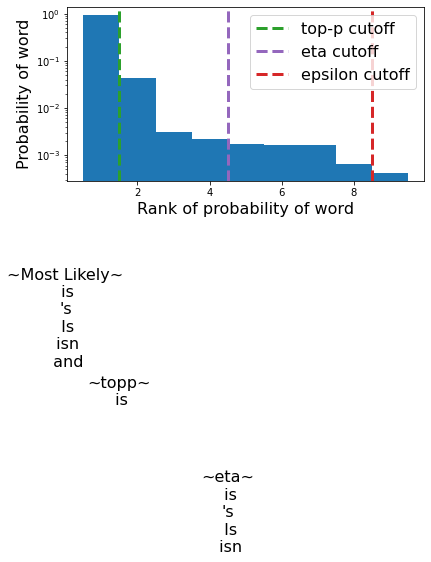

In [8]:
evaluation_string =  '<|endoftext|> My name X', # Modify me!

report_truncation(evaluation_string)

# Uncomment if you want to download
#from google.colab import files
#files.download('truncation.png') 